# Решение акустического 2Д волнового уравнения конечно-разностным методом

## 1. Подготовка к расчётам

Импорт библиотек для Python

In [2]:
from __future__ import division
import numpy as np
from bruges.filters.wavelets import ricker
import matplotlib.pyplot as plt
from scipy.signal import convolve
import skimage.filters
#import skimage.io

#### 1.1. Задаем сетку, шаги по x и по y, шаг по времени

In [3]:
dt = 1e-4 #seconds
dx = 1    #meters
dz = 1    #meters

#Size of model in meters
nx = 100
nz = 80

tmax = 0.1 #seconds
t_array = np.arange(0, tmax, dt) #array of times

#### 1.2. Задаем скоростную модель: граница на глубине 50 м, дифрактор над ней

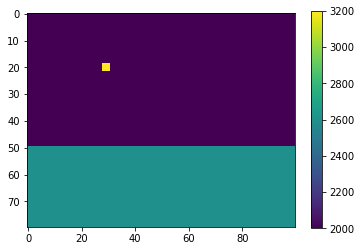

In [4]:
vp = 2000.0     #m/s
vmodel = vp * np.ones((nx, nz), dtype = float)

vmodel[:, 50:] = vp*1.3
vmodel[28:31, 19:22] = vp*1.6

#display
im_v = plt.imshow(vmodel.T)
plt.colorbar()
plt.show()


#### 1.3. Задаем импульс

функция для импульса рикера импортируется из внешней библиотеки bruges

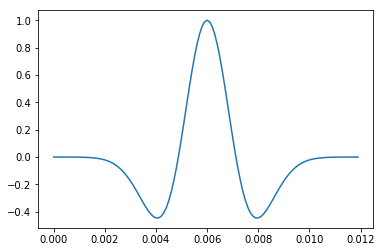

In [5]:
wav1 = ricker(duration = 0.012, dt = dt, f = 200)
plt.plot(np.arange(0, 0.012, dt), wav1)
plt.show()

#### 1.4. Задаем позицию источника

In [6]:
isx = 50
isz = 0

## 2. Создание функции для пошагового расчёта волнового поля

#### 2.1. Метод

Если по ходу возникают трудности, обращаемся к [этому документу](w3.pppl.gov/m3d/1dwave/ln_fdtd_1d.pdf)


Итак, пусть $u(x, z, t)$ - массив амплитуд. Это *скалярный* параметр, заданный в каждой точке пространства $(x_n, y_m)$ в каждый момент времени $t_k$. 
Таким образом, $u(x, z, t = t_k)$ обозначает снимок волнового поля (snapshot) в момент времени $t_k$. В нашем случае, это будет амплитуда волны давления, ~~но это не столь важно~~.


Для упрощения записи давайте в дальнейшем будем писать так. Поскольку сетка у нас с постоянным шагом по каждому направлению, это означает, что $x_n = n \Delta x$, $z_m = m \Delta z$, $t_k = k \Delta t$. Тогда будем для краткости записывать $u(x = x_n, z=z_m, t=t_k)$ как $u_{m,n}^k$. Верхний индекс отвечает за номер отсчёта времени, нижние два - пространственные координаты.

Теперь запишем 2Д волновое уравнение
$$ \frac{\partial^2{u(x,t)}}{\partial{x^2}} = \frac{1}{c^2} \frac{\partial^2{u(x,t)}}{\partial{t^2}} , $$

Поскольку моделирование конечно-разностное, заменяем все производные на конечные разности, и вот что у нас получается (если выразить $ u_{m,n}^{k+1} $, перенеся его в левую сторону от знака равенства):

$$ u_{m,n}^{k+1} = r^2 \left(u_{m+1,n}^k + u_{m,n+1}^k - 4u_{m,n}^k + u_{m-1,n}^k + u_{m,n-1}^k \right) +2u_{m,n}^k - u_{m,n}^{k-1} ,$$ 
где $r = c \Delta t / \Delta x$

Внимательный читатель может заметить, что вот оно, собственно, и всё. Тут написано, как рассчитать $ u_{m,n}^{k+1} $, то есть  волновое поле на $ k+1 $ шаге.
Итак, для расчёта поля $u$ на шаге $k+1$ в точке $(x_n, z_m)$, надо сложить и перемножить значения $u$ в пяти точках на шаге $k$ (предыдущем) и одной точке на позапрошлом шаге $k-1$. Так шаг за шагом можно рассчитать $u$ для всех значений времени от начала `t0 + 2*dt` до максимального значения времени `tmax`. 
    

#### 2.2. Начальные условия

Как уже было сказано, волновое поле на каждом шаге высчитывается из значений на двух предыдущих шагах. 
Так, для расчёта волнового поля на втором шаге $u_{m,n}^{2}$ надо сначала рассчитать волновое поле на первом и нулевом шагах  $u_{m,n}^{1}$ и $u_{m,n}^{0}$.
Понятно, что мы их вычислить не можем, их надо задать. Это и называется *начальными условиями*.
 
Очень удачно, что для простоты их можно просто заполнить нулями.

Пора создать трехмерный массив `u_all` для значений амплитуды $u(x,z,t)$

Для начала аполним его весь ~~угадайте, чем~~ нулями

In [7]:
u_all = np.zeros((np.shape(vmodel)[0], np.shape(vmodel)[1], int(tmax/dt)), dtype = float)

r = vmodel*dt/dx

#### 2.3. Задание источника колебаний (граничное условие)

Для моделирования упругих колебаний нужно учесть положение источника и его сигнатуру, т.е. то, какой импульс он излучает. Импульс мы уже задали на шаге 1.3, теперь надо его прикрутить к позиции источника и к уравнению. Сделать это весьма просто.

Надо просто на каждом шаге $t_k$ добавлять к значению $u$ в точке с координатами источника `[isx, isz]` число, соответствующее амплитуде импульса в момент времени $t_k$.

#### 2.4. Комментарии по поводу расчётов

Величина в скобках в формуле для конечно-разностного расчёта волнового уравнения содержит пять элементов поля $u$ на предыдущем шаге $k$ с разными коэффициентами ![Image](http://article.sciencepublishinggroup.com/journal/654/6540997/image012.jpg)





Расчёт этой их комбинации представляет собой не что иное, как 2-Д свертку массива $u(x,z,t=t_k)$ (снимка волнового поля на $k$-м шаге) c оператором

$$ D = \left( \matrix{ 0 & 1 & 0 \cr 1 & -4 & 1 \cr 0 & 1 & 0}\right) $$

#### 2.5. Псевдо-код для расчёта

Запишем алгоритм конечно-разностного решения 2Д акустического волнового уравнения:

1. Задать начальные условия на первых двух моментах времени: $u_0$, $u_1$
2. Для каждого $k$-го шага, начиная с $k=2$ и до конца:
   - сворачиваем $u_{k-1}$ с оператором $D$
   - поточечно умножаем результат на $r=c \Delta t / \Delta x$ и прибавляем $2u_{m,n}^k - u_{m,n}^{k-1}$
   - Добавляем амплитуду функции источника в данный момент времени к $u$ в точке `[isx, isz]`
   
Для удобства создадим функцию `solve_fd2d`, которая будет выполнять расчёты на каждом шаге:

#### 2.7. Функция для пошагового расчёта волнового уравнения

In [8]:
def solve_fd2d(v, w, vmodel, r, dt, dx, dz):
    """
    Compute wave amplitude at the next k-th time step
    v = snapshot of amplitude at last step (k-1)
    w = snapshot of amplitude at previous step (k-2).
    """
    
    D = np.array([[0,1,0],[1,-4,1],[0,1,0]])
    
    return 2*v - 1*w + (r**2)*convolve(v, D, mode='same')

## 3. Собственно расчёты

Запишем цикл, где для каждого отсчёта времени будем вызывать только что написанную функцию, а если источик активен - добавлять в положенную точку пространства амплитуду, соответствующую импульсу.

In [9]:
for k, tk in enumerate(t_array):
    if k >= 2: # we need to start from step 2 because step 1 and step 0 are initial conditions
        v = u_all[:,:,k-1]
        w = u_all[:,:,k-2]
        
        u = solve_fd2d(v, w, vmodel, r, dt, dx, dz)

        if k < len(wav1): # if source is active, add its amplitudes to the wavefield
            u[isx, isz] = u[isx, isz] + wav1[k]

        u_all[:,:,k] = u


Ну вот и все, расчёты на этом закончены. Осталось посмотреть на результат. Глянем на итерации 150, 250, 370, 500

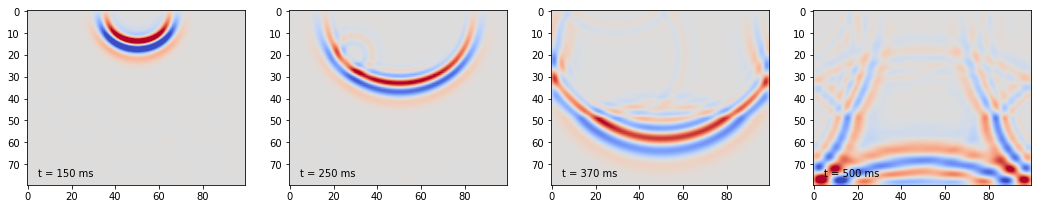

In [10]:
iterations_to_show = [150, 250, 370, 500]
fgr, axs = plt.subplots(1,len(iterations_to_show), figsize = (18,10))
for j, ax in enumerate(axs):
    ax.imshow(u_all[:, :, iterations_to_show[j]].T, cmap = 'coolwarm_r', vmin = -1, vmax = 1, interpolation='bilinear')
    ax.annotate("t = {0} ms".format(iterations_to_show[j]), xy=(0.05, 0.05), xycoords="axes fraction")
plt.show()

## 4.  Ввод поглощающих граничных условий

#### 4.1. Что это и как это сделать
Сразу бросается в глаза, что что-то не так с третьей и четвертой картинкой. Ну да, мы видим там в основном отражения от границ модели, и они гораздо ярче полезной отраженной волны. К счастью, не мы первые с этим столкнулись, и придумано много способов с этими эффектами бороться. Мы будем использовать поглощающие граничные условия, или absorbing boundary conditions (ABC).

Не будем вдаваться в подробности, как выводить эти уравнения. Суть заключается в том, что в каждый момент времени для каждой волны, пришедшей на край модели, на этой границе модели генерируется волна, равная ей по амплитуде и противоположная по фазе. В результате эта искусственно создаваемая волна гасит все колебания, дошедшие до границы модели.

После преобразований получаются следующие уравнения.

Для правой границы ($x = x_N$):

$$u_{N, m}^{k+1} = u_{N-1, m}^{k} + \frac{r-1}{r+1} \left( u_{N-1, m}^{k+1} - u_{N, m}^{k} \right) $$

Для левой границы:

$$u_{0, m}^{k+1} = u_{1, m}^{k} + \frac{r-1}{r+1} \left( u_{1, m}^{k+1} - u_{0, m}^{k} \right) $$

Для ~~днища~~ нижней границы:

$$u_{n, M}^{k+1} = u_{n, M-1}^{k} + \frac{r-1}{r+1} \left( u_{n, M-1}^{k+1} - u_{n, M}^{k} \right) $$


Теперь надо лишь дописать эти уравнения в нашу функцию, чтобы она на каждом шаге перерасчитывала значения $u$ в соответствии с этими уравнениями граничных условий.
Удобнее всего сделать это в виде новой функции, `solve_fd2d_abc`:

In [11]:
def solve_fd2d_abc(v, w, vmodel, r, dt, dx, dz):
    """
    Compute wave amplitude at the next k-th time step
    with boundary conditions
    
    v = snapshot of amplitude at last step (k-1)
    w = snapshot of amplitude at previous step (k-2).
    """
    
    D = np.array([[0,1,0],[1,-4,1],[0,1,0]])
    u_out = 2*v - 1*w + (r**2)*convolve(v, D, mode='same')
    
    #bottom
    u_out[:,-1] = v[:,-2] + (r[:,-1] - 1)/(r[:,-1] + 1)*(u_out[:,-2] - v[:,-1])
    #right
    u_out[-1,:] = v[-2,:] + (r[-1,:] - 1)/(r[-1,:] + 1)*(u_out[-2,:] - v[-1,:])
    #left
    u_out[0,:] = v[1,:] + (r[0,:] - 1)/(r[0,:] + 1)*(u_out[1,:] - v[0,:])
    
    return u_out

#### 4.2. Заново рассчитываем всё

Создадим новый 3-Д массив амплитуд `u_abc`, заполним нулями и снова пройдемся в цикле по всем отсчётам времени, но теперь с новой функцией, поглощающей все паразитные отражения

In [12]:
u_abc = np.zeros((np.shape(vmodel)[0], np.shape(vmodel)[1], int(tmax/dt)), dtype = float)
for k, tk in enumerate(t_array):
    if k >= 2: # we need to start from step 2 because step 1 and step 0 are initial conditions
        v = u_abc[:,:,k-1]
        w = u_abc[:,:,k-2]
        
        u = solve_fd2d_abc(v, w, vmodel, r, dt, dx, dz)

        if k < len(wav1): # if source is active, add its amplitudes to the wavefield
            u[isx, isz] = u[isx, isz] + wav1[k]

        u_abc[:,:,k] = u


#### 4.3. Результаты. Сейсмограммы.

Ок посмотрим, что получилось:

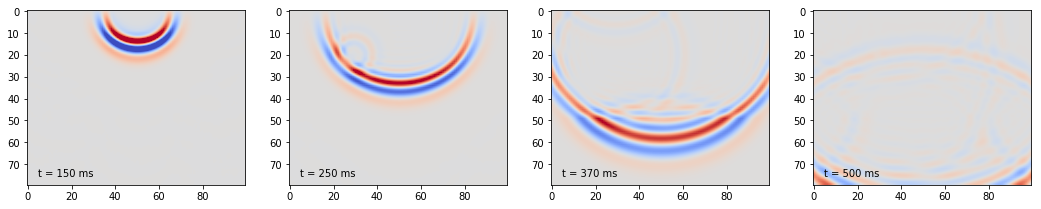

In [13]:
fgr, axs = plt.subplots(1,len(iterations_to_show), figsize = (18,10))
for j, ax in enumerate(axs):
    ax.imshow(u_abc[:, :, iterations_to_show[j]].T, cmap = 'coolwarm_r', vmin = -1, vmax = 1, interpolation='bilinear')
    ax.annotate("t = {0} ms".format(iterations_to_show[j]), xy=(0.05, 0.05), xycoords="axes fraction")
plt.show()

Ура, заработало.

Сейсмограммы - это не что иное, фрагмент нашего 3-Д массива для $z = 0$, т.е. $u(x,z=0,t)$.

Сравним сейсмограммы, полученные с поглощающими граничными уловиями и без них:

In [14]:
surface_record_no_bc = u_all[:,1,:]
surface_record_raw = u_abc[:,1,:]

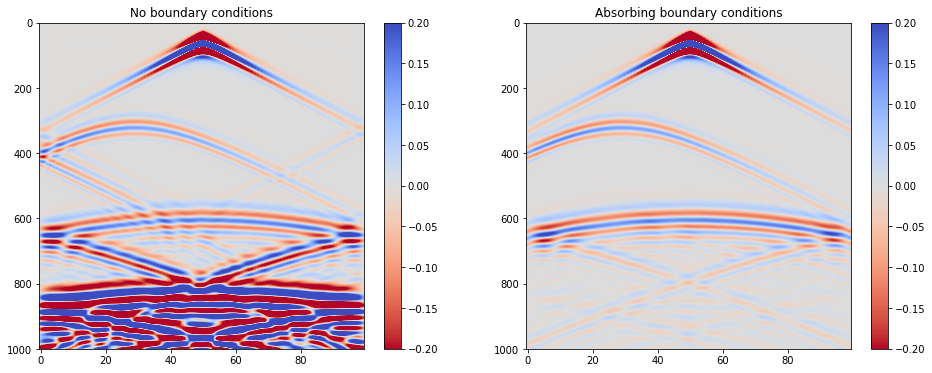

In [15]:
#display

fgr2, axs2 = plt.subplots(1,2, figsize = (16,6))
im1=axs2[0].imshow(surface_record_no_bc.T, cmap = 'coolwarm_r', vmin = -0.2, vmax = 0.2, interpolation='bilinear', aspect='auto')
im2=axs2[1].imshow(surface_record_raw.T, cmap = 'coolwarm_r', vmin = -0.2, vmax = 0.2, interpolation='bilinear', aspect='auto')
axs2[0].set_title('No boundary conditions')
axs2[1].set_title('Absorbing boundary conditions')
fgr2.colorbar(im1, ax = axs2[0])
fgr2.colorbar(im2, ax = axs2[1])
plt.show()

На сейсмограммах видим отраженную волну (на 600 - 700 мс), дифрагированную волну, остатки недоподавленных отражений от границ модели.

Чтобы устранить паразитные отражения  полностью, нужно использовать какие-нибудь другие, более мощные граничные условия (например, perfectly matched layer, PML), но это уже сложновато.